In [1]:
cd ..

/lustre/groups/ml01/workspace/carlo.dedonno/scarches_repo/scarches


In [2]:
import os
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

from scarches.dataset.trvae.data_handling import remove_sparsity
from scarches.models.scpoli import scPoli

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/lustre/groups/ml01/workspace/carlo.dedonno/scarches_repo/scarches/scarches/dataset/__init__.py:9: UserWarning: In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).
  warnings.warn('In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).')
/lustre/groups/ml01/workspace/carlo.dedonno/scarches_repo/scarches/scarches/models/__init__.py:11: UserWarning: In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and 
 captum (see https://github.com/pytorch/captum).
  warnings.warn('In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and \n captum (see https://github.com/pytorch/captum).')
Global seed set to 0
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationW

In [3]:
adata = sc.read('../../lataq_reproduce/data/pancreas.h5ad')
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    obsm: 'X_seurat', 'X_symphony'

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


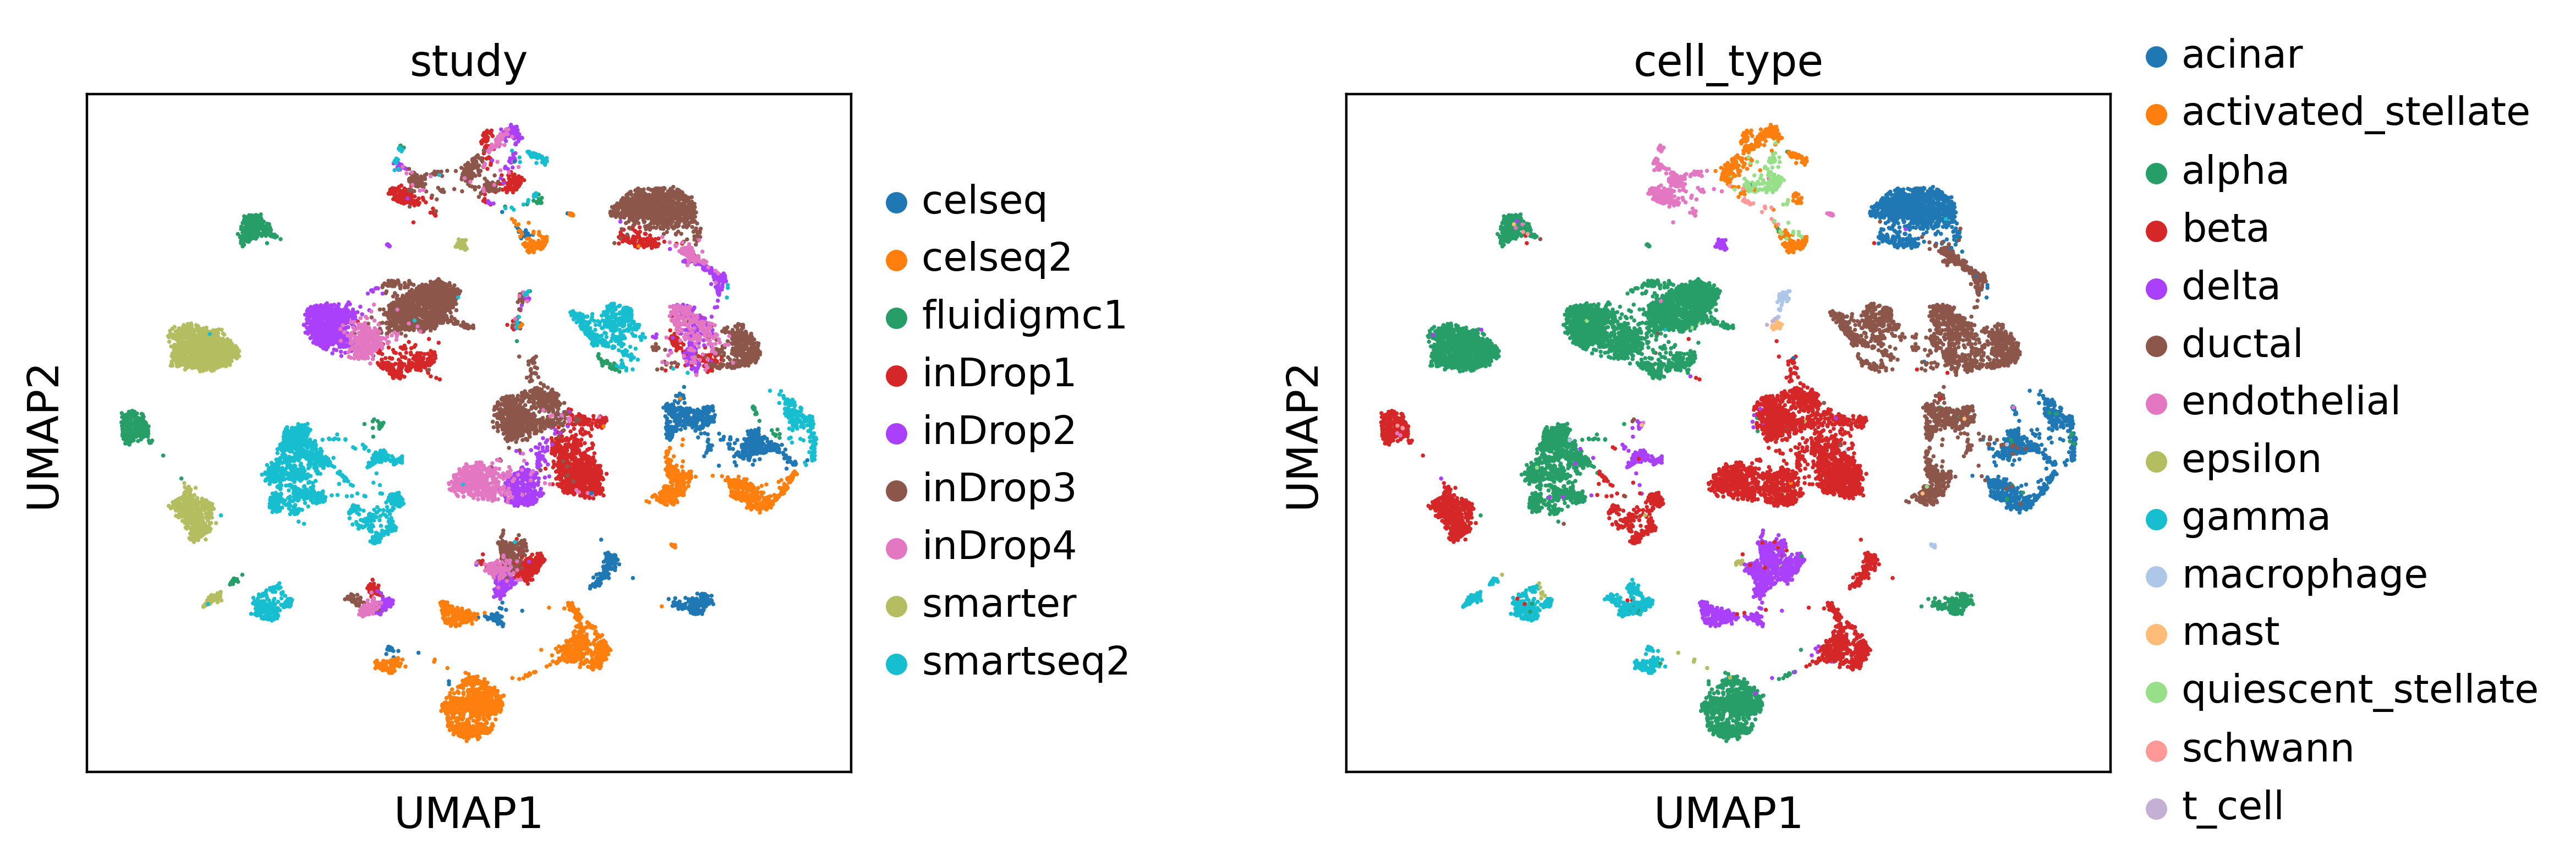

In [5]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.5)

In [6]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_landmark_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

condition_key = 'study'
cell_type_key = ['cell_type']
reference = [
    'inDrop1', 
    'inDrop2', 
    'inDrop3', 
    'inDrop4', 
    'fluidigmc1', 
    'smartseq2', 
    'smarter'
]
query = ['celseq', 'celseq2']

# Reference - query split
We split our data in a group of reference datasets to be used for reference building, and a group of query datasets that we will map.

In order to simulate an unknown cell type scenario, we manually remove beta cells from the reference.

In [7]:
adata.obs['query'] = adata.obs[condition_key].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')
source_adata = adata[adata.obs.study.isin(reference)].copy()
source_adata = source_adata[~source_adata.obs.cell_type.str.contains('alpha')].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [8]:
source_adata, target_adata

(AnnData object with n_obs × n_vars = 8634 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
     uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors'
     obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 3289 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
     uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors'
     obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities')

# Train reference scPoli model on fully labeled reference data

In [9]:
scpoli_model = scPoli(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    embedding_dim=5,
)

Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 5
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 5
	Hidden Layer 1 in/out: 256 64
	Mean/Var Layer in/out: 64 10
Decoder Architecture:
	First Layer in, out and cond:  10 64 5
	Hidden Layer 1 in/out: 64 256
	Output Layer in/out:  256 4000 



In [10]:
scpoli_model.train(
    n_epochs=50,
    pretraining_epochs=40,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)

 |████████████████████| 100.0%  - val_loss: 1083.0758754185 - val_trvae_loss: 1075.1029924665 - val_landmark_loss: 7.9728902408 - val_labeled_loss: 1.5945780618
Saving best state of network...
Best State was in Epoch 48


# Reference mapping of unlabeled query datasets

In [11]:
scpoli_query = scPoli.load_query_data(
    adata=target_adata,
    reference_model=scpoli_model,
    labeled_indices=[],
)

Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 5
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 5
	Hidden Layer 1 in/out: 256 64
	Mean/Var Layer in/out: 64 10
Decoder Architecture:
	First Layer in, out and cond:  10 64 5
	Hidden Layer 1 in/out: 64 256
	Output Layer in/out:  256 4000 

7


In [12]:
scpoli_query.train(
    n_epochs=50,
    pretraining_epochs=40,
    eta=5
)

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
 |████████████████----| 80.0%  - val_loss: 1845.1048583984 - val_trvae_loss: 1845.1048583984
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 9 clusters.
 |████████████████████| 100.0%  - val_loss: 1827.0964762370 - val_trvae_loss: 1827.0897216797 - val_landmark_loss: 0.0067567600 - val_unlabeled_loss: 1.3513519764
Saving best state of network...
Best State was in Epoch 49


# Label transfer from reference to query

In [13]:
results_dict = scpoli_query.classify(
    target_adata.X, 
    target_adata.obs[condition_key], 
)

Let's check the label transfer performance we achieved.

In [14]:
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key[i]]["preds"]
    results_dict[cell_type_key[i]]["uncert"]
    classification_df = pd.DataFrame(
        classification_report(
            y_true=target_adata.obs[cell_type_key[i]],
            y_pred=preds,
            output_dict=True,
        )
    ).transpose()
print(classification_df)

In [16]:
#get latent representation of reference data
scpoli_query.model.eval()
data_latent_source = scpoli_query.get_latent(
    source_adata.X, 
    source_adata.obs[condition_key].values,
    mean=True
)

adata_latent_source = sc.AnnData(data_latent_source)
adata_latent_source.obs = source_adata.obs.copy()

#get latent representation of query data
data_latent= scpoli_query.get_latent(
    target_adata.X, 
    target_adata.obs[condition_key].values,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = target_adata.obs.copy()

#get label annotations
adata_latent.obs['cell_type_pred'] = results_dict['cell_type']['preds'].tolist()
adata_latent.obs['cell_type_uncert'] = results_dict['cell_type']['uncert'].tolist()
adata_latent.obs['classifier_outcome'] = (
    adata_latent.obs['cell_type_pred'] == adata_latent.obs['cell_type']
)


#join adatas
adata_latent_full = adata_latent_source.concatenate(
    [adata_latent], 
    batch_key='query'
)
adata_latent_full.obs['cell_type_pred'][adata_latent_full.obs['query'].isin(['0'])] = np.nan
sc.pp.neighbors(adata_latent_full, n_neighbors=15)
sc.tl.umap(adata_latent_full)

<AxesSubplot: title={'center': 'cell_type_pred'}, xlabel='UMAP1', ylabel='UMAP2'>

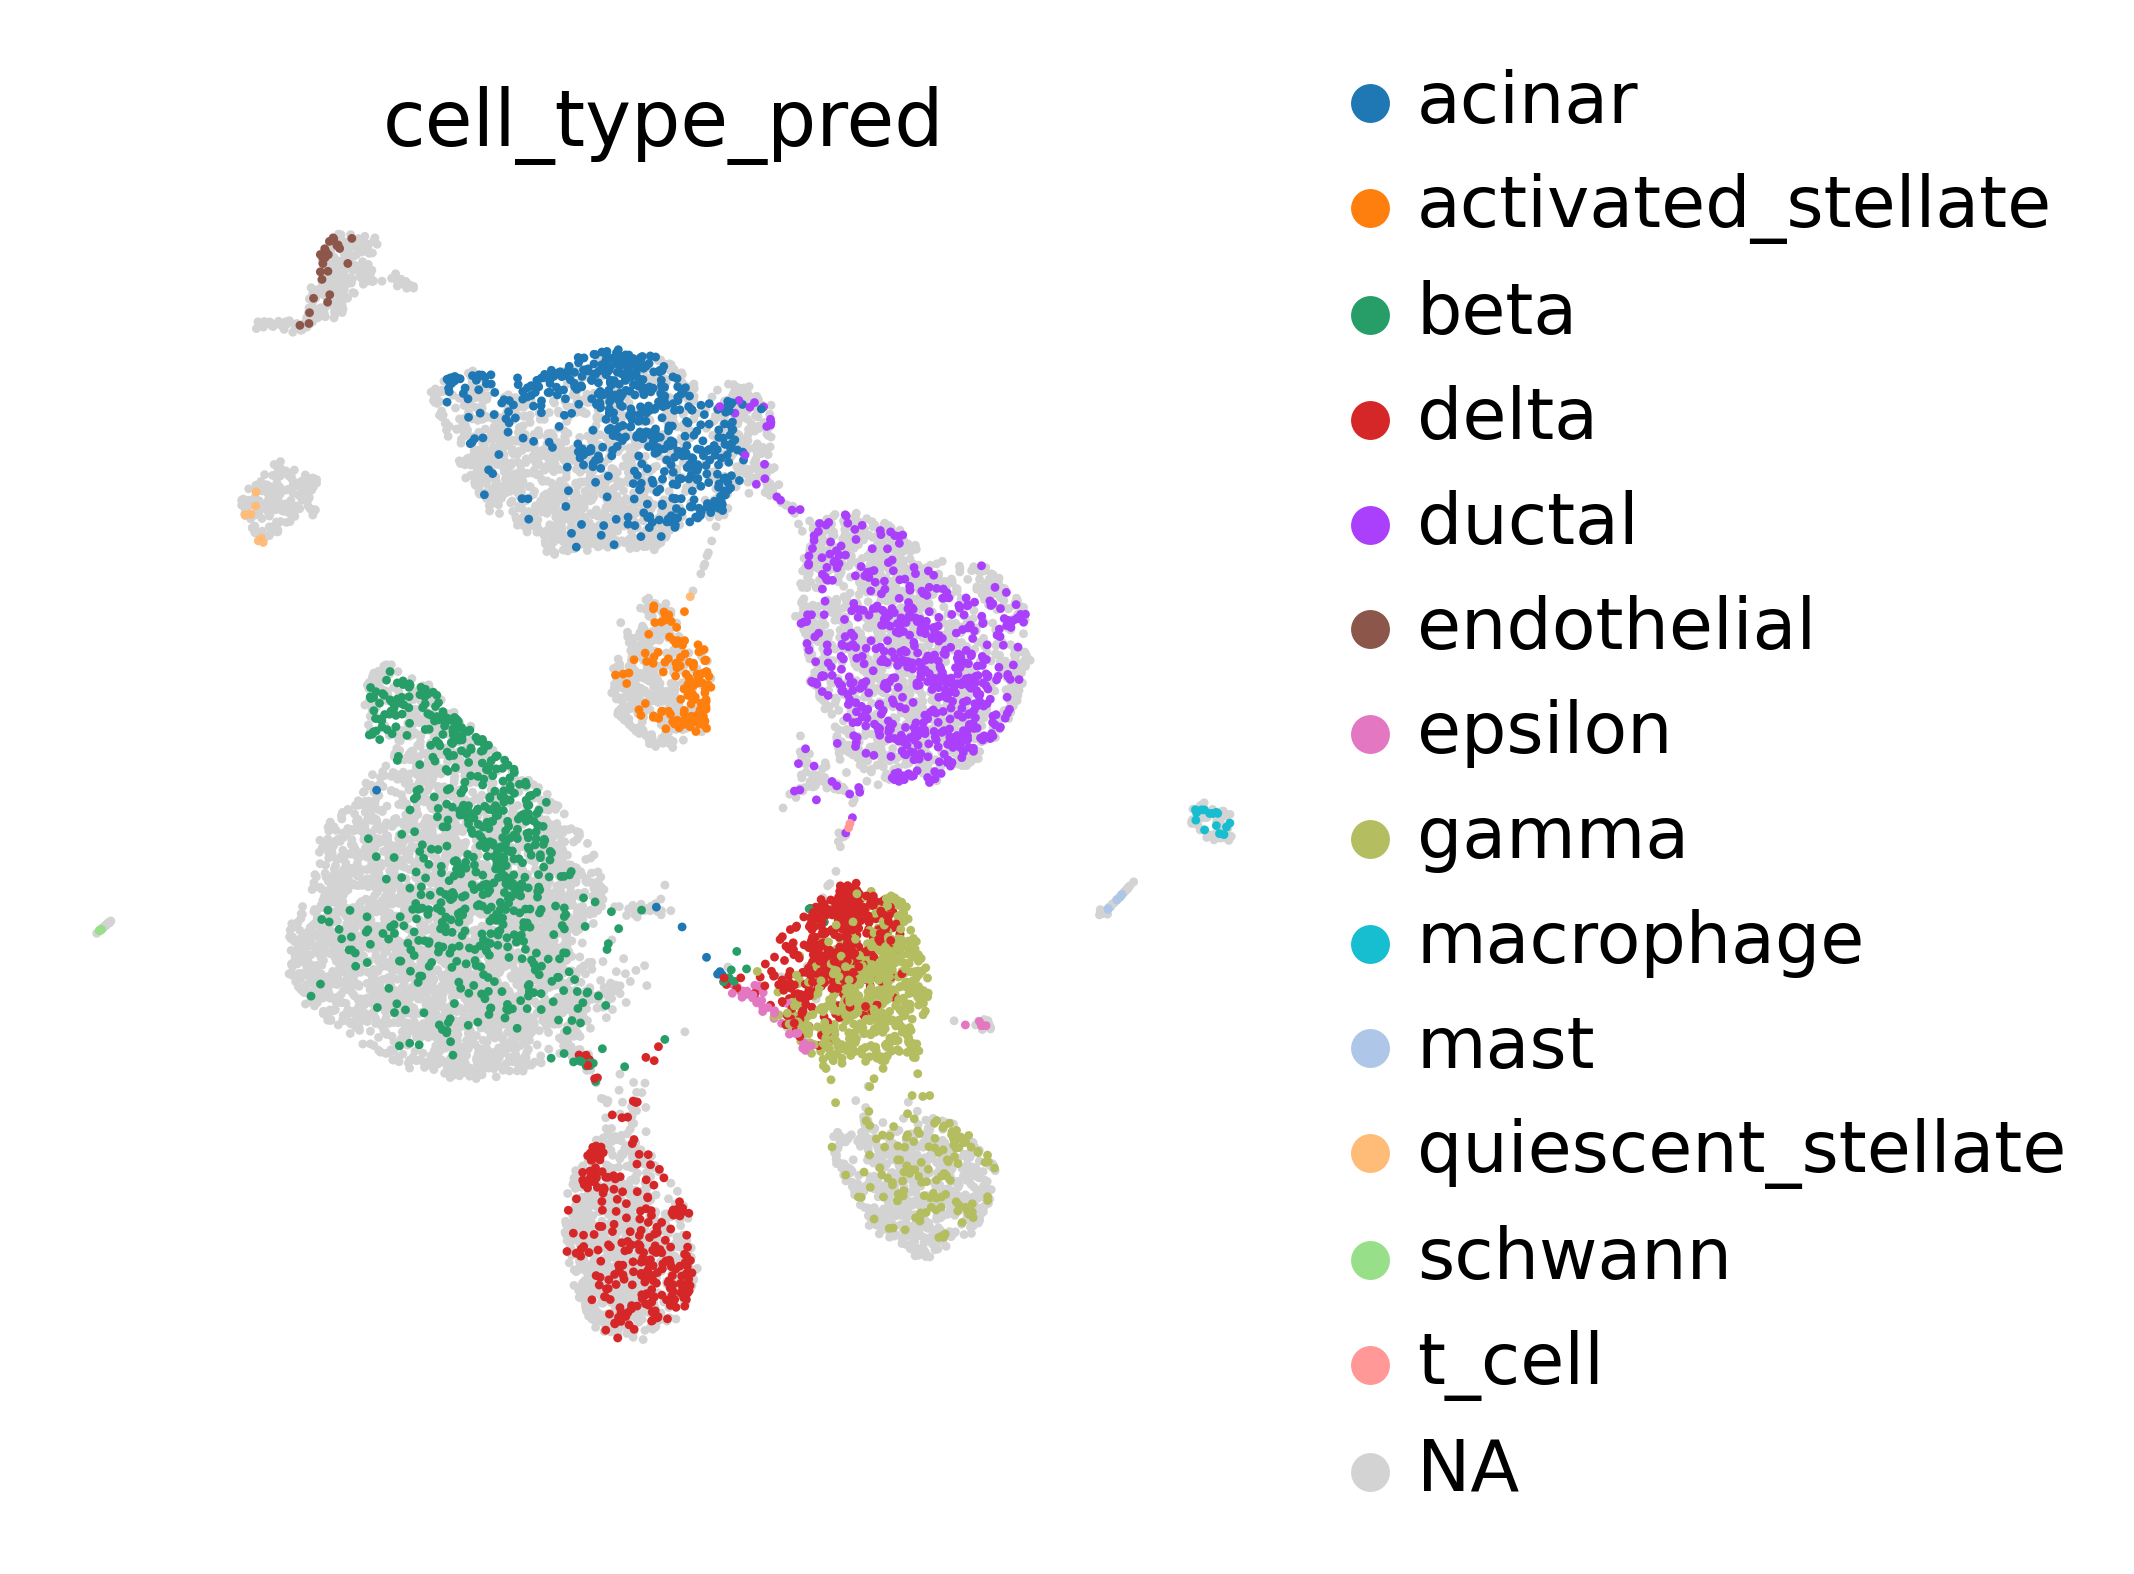

In [17]:
sc.pl.umap(
    adata_latent_full, 
    color='cell_type_pred',
    show=False, 
    frameon=False,
)

<AxesSubplot: title={'center': 'study'}, xlabel='UMAP1', ylabel='UMAP2'>

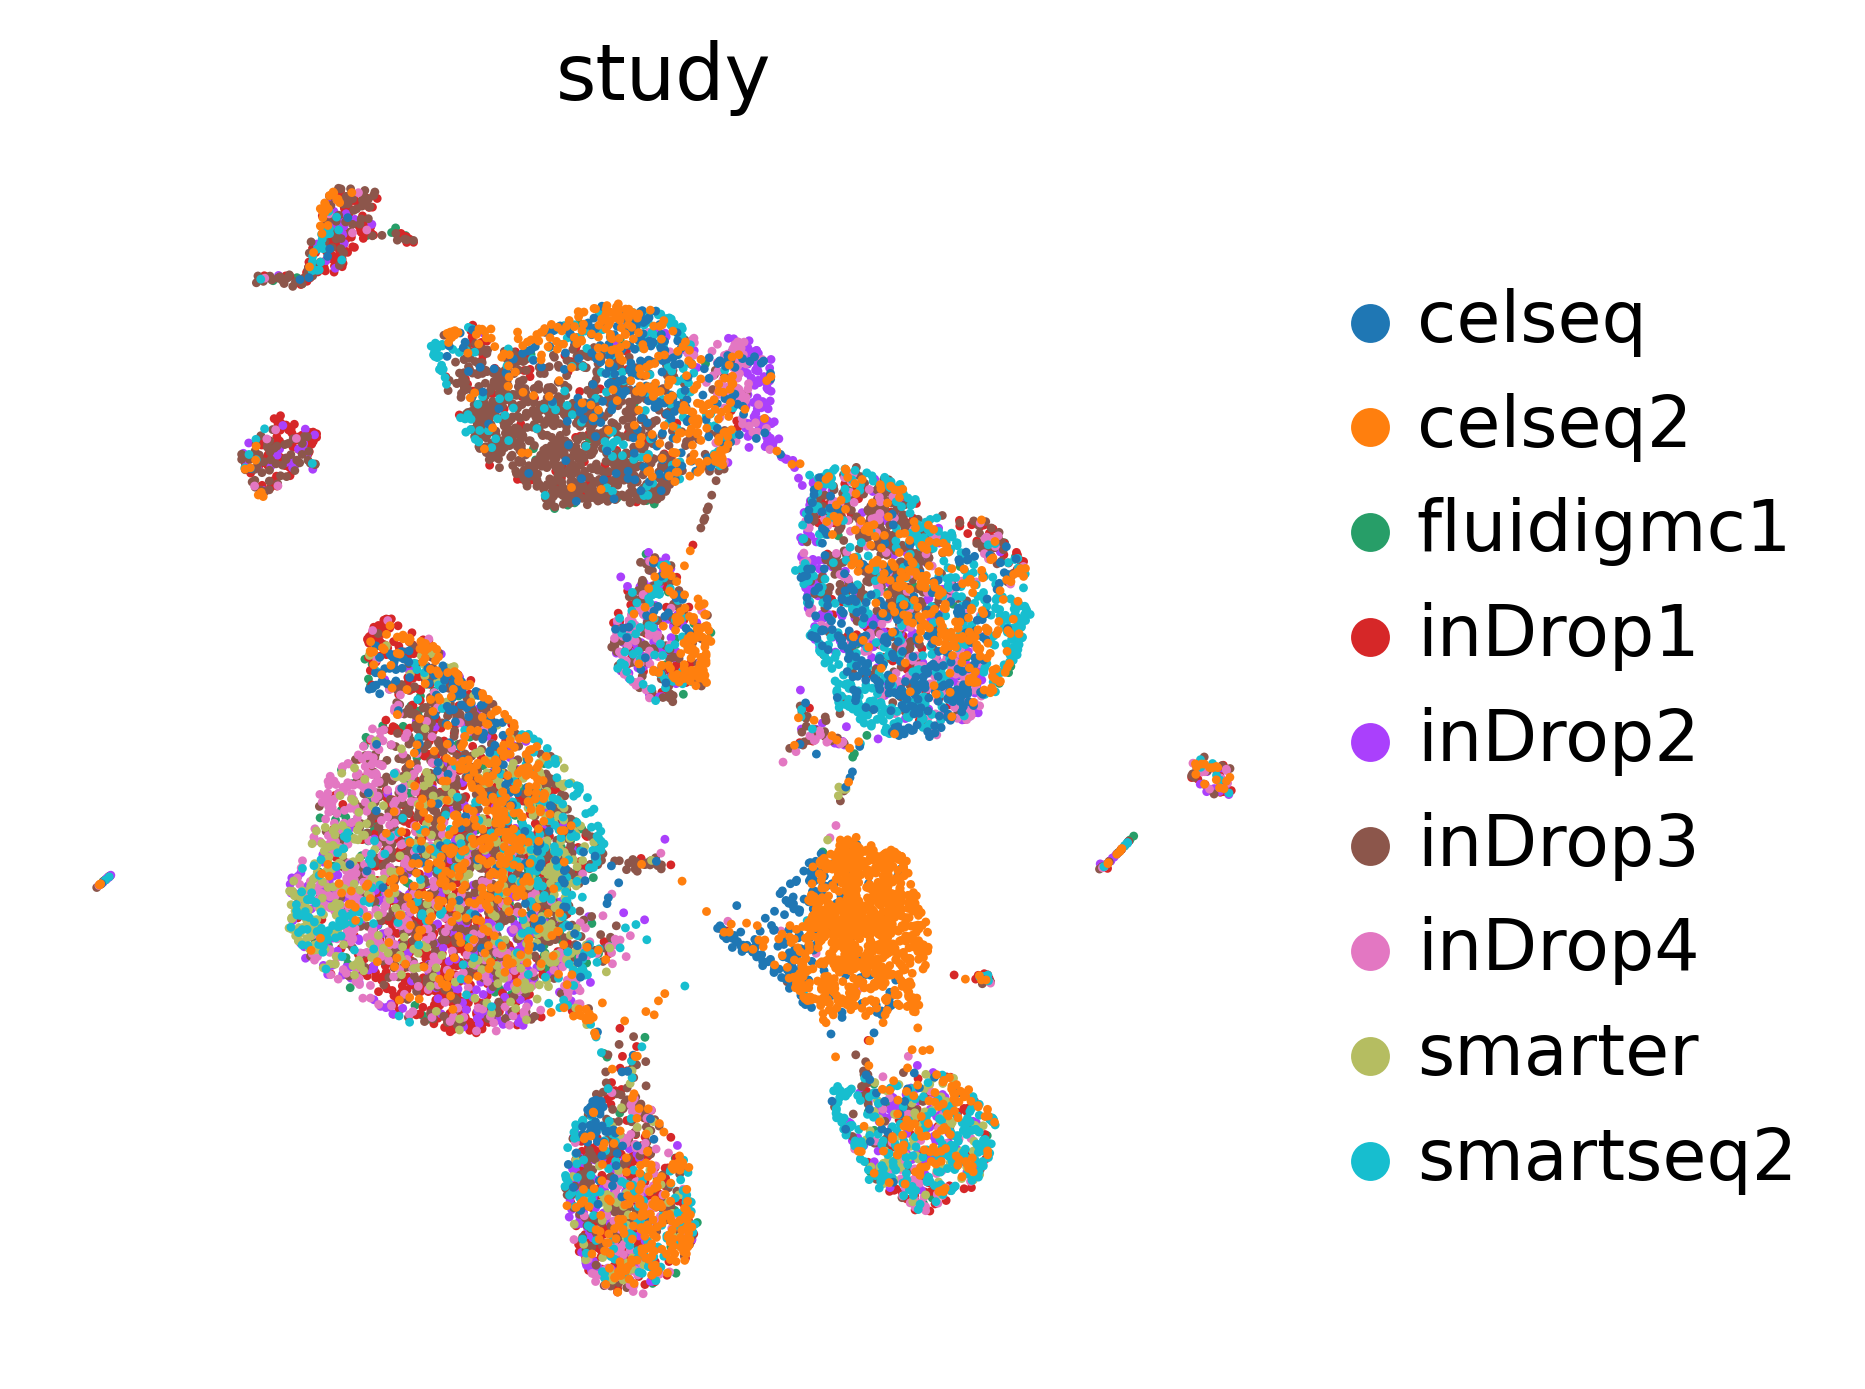

In [18]:
sc.pl.umap(
    adata_latent_full, 
    color='study',
    show=False, 
    frameon=False,
)

# Inspect uncertainty
We can look at the uncertainty of each prediction and either select a threshold after visual inspection or by looking at the percentiles of the uncertainties distribution.

<AxesSubplot: title={'center': 'cell_type_uncert'}, xlabel='UMAP1', ylabel='UMAP2'>

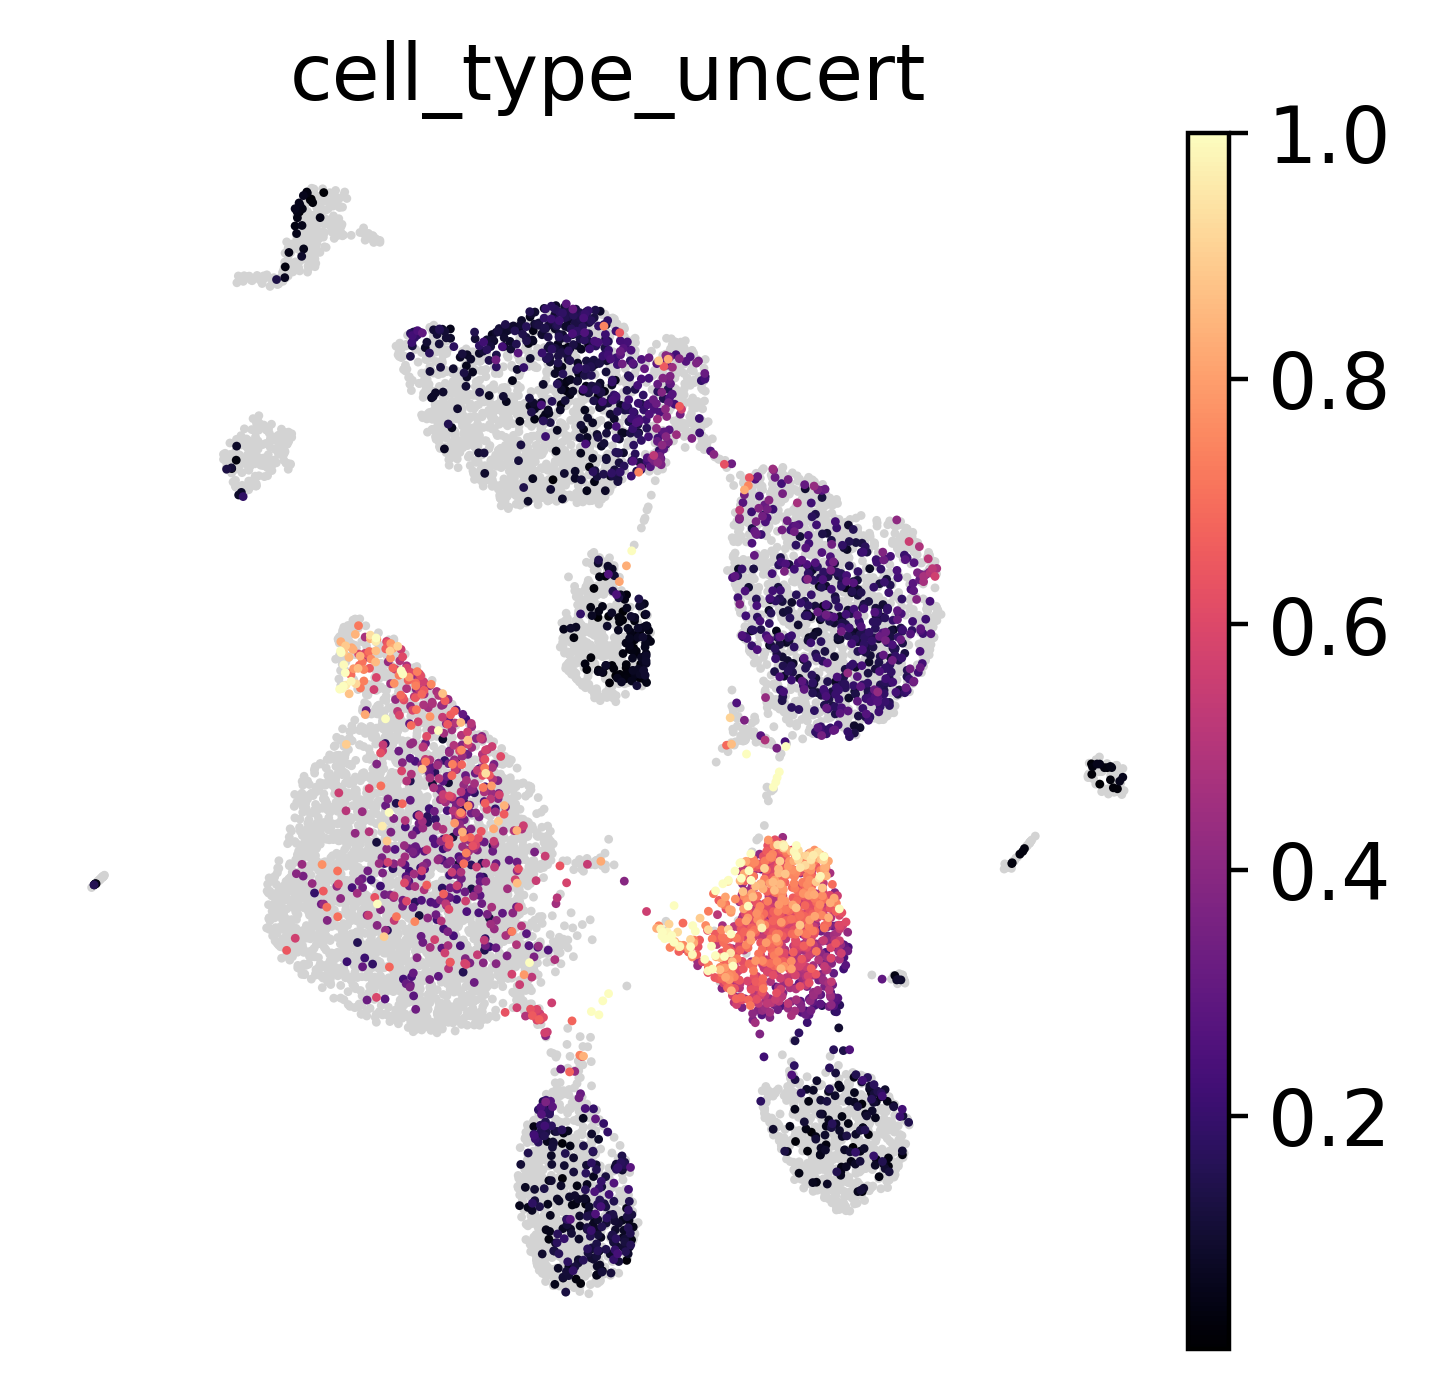

In [19]:
sc.pl.umap(
    adata_latent_full, 
    color='cell_type_uncert',
    show=False, 
    frameon=False,
    cmap='magma',
    vmax=1
)

# Sample embeddings

We can extract the conditional embeddings learnt by scPoli and analyse them.

In [26]:
embedding = scpoli_query.model.embedding.weight.detach().cpu().numpy()

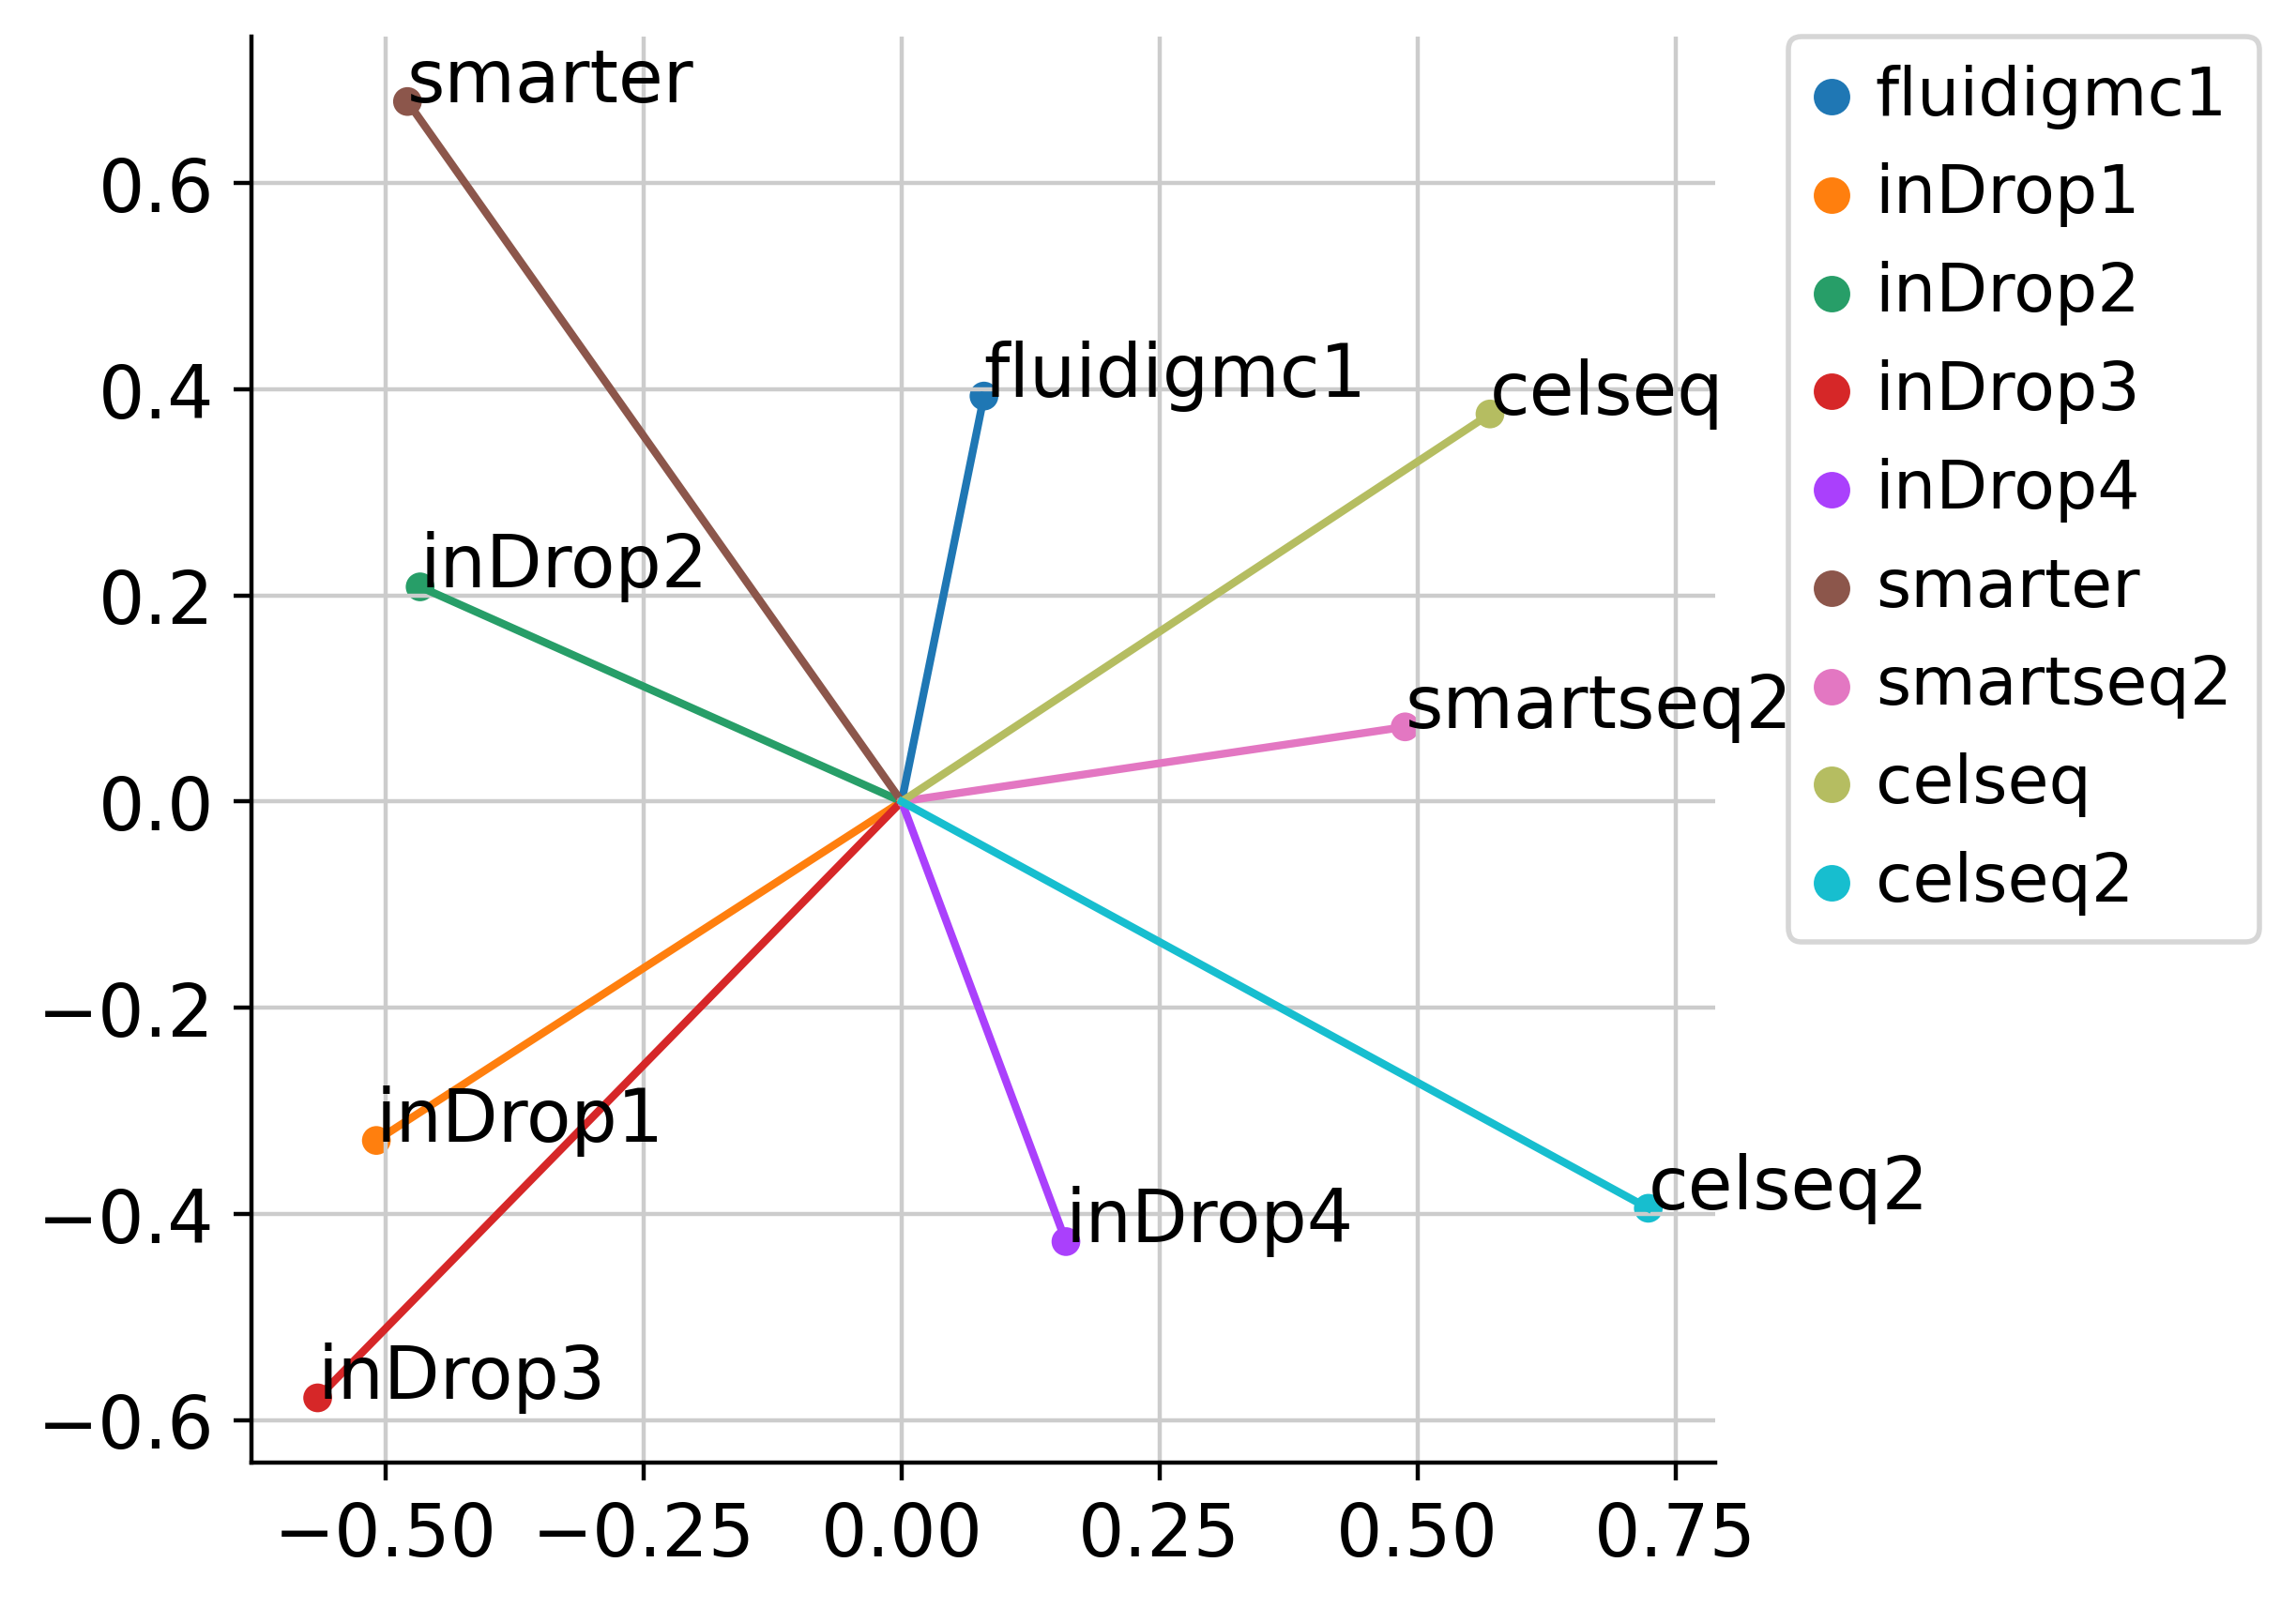

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(embedding)
conditions = scpoli_query.conditions_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=emb_pca[:, 0], y=emb_pca[:, 1], hue=conditions, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(conditions):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()